# Dataset

In [5]:
with open('names.txt') as f:
    content = f.read()
    words = content.splitlines()

print("Dataset size: ", len(words))
print("Smallest length: ", min(len(w) for w in words))
print("Largest length: ", max(len(w) for w in words))
print("Examples: ", words[:10])

Dataset size:  32033
Smallest length:  2
Largest length:  15
Examples:  ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


# Examining & Counting Bigrams

In [6]:
freq: dict[tuple[str, str], int] = {}
# Create bigrams of individual character pairs, including start and end. Keep
# statistics about likelihood of pairs of one character following another
for w in words:
    chs = ['<S>']  + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        freq[bigram] = freq.get(bigram, 0) + 1

In [7]:
most_common = list(freq.items())
most_common.sort(reverse=True, key=lambda kv: kv[1])
most_common[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

# Count bigrams using Torch Tensors

In [40]:
import torch

# Use tensors to capture the frequency of bigrams. First lets determine the characters
# in the dataset used as offsets within the tensor.
chars = sorted(list(set(''.join(words))))
stoi = { s: i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }

N = torch.zeros(len(stoi), len(stoi), dtype=torch.int32)
for w in words:
    chs = ['.']  + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] +=1

(-0.5, 26.5, 26.5, -0.5)

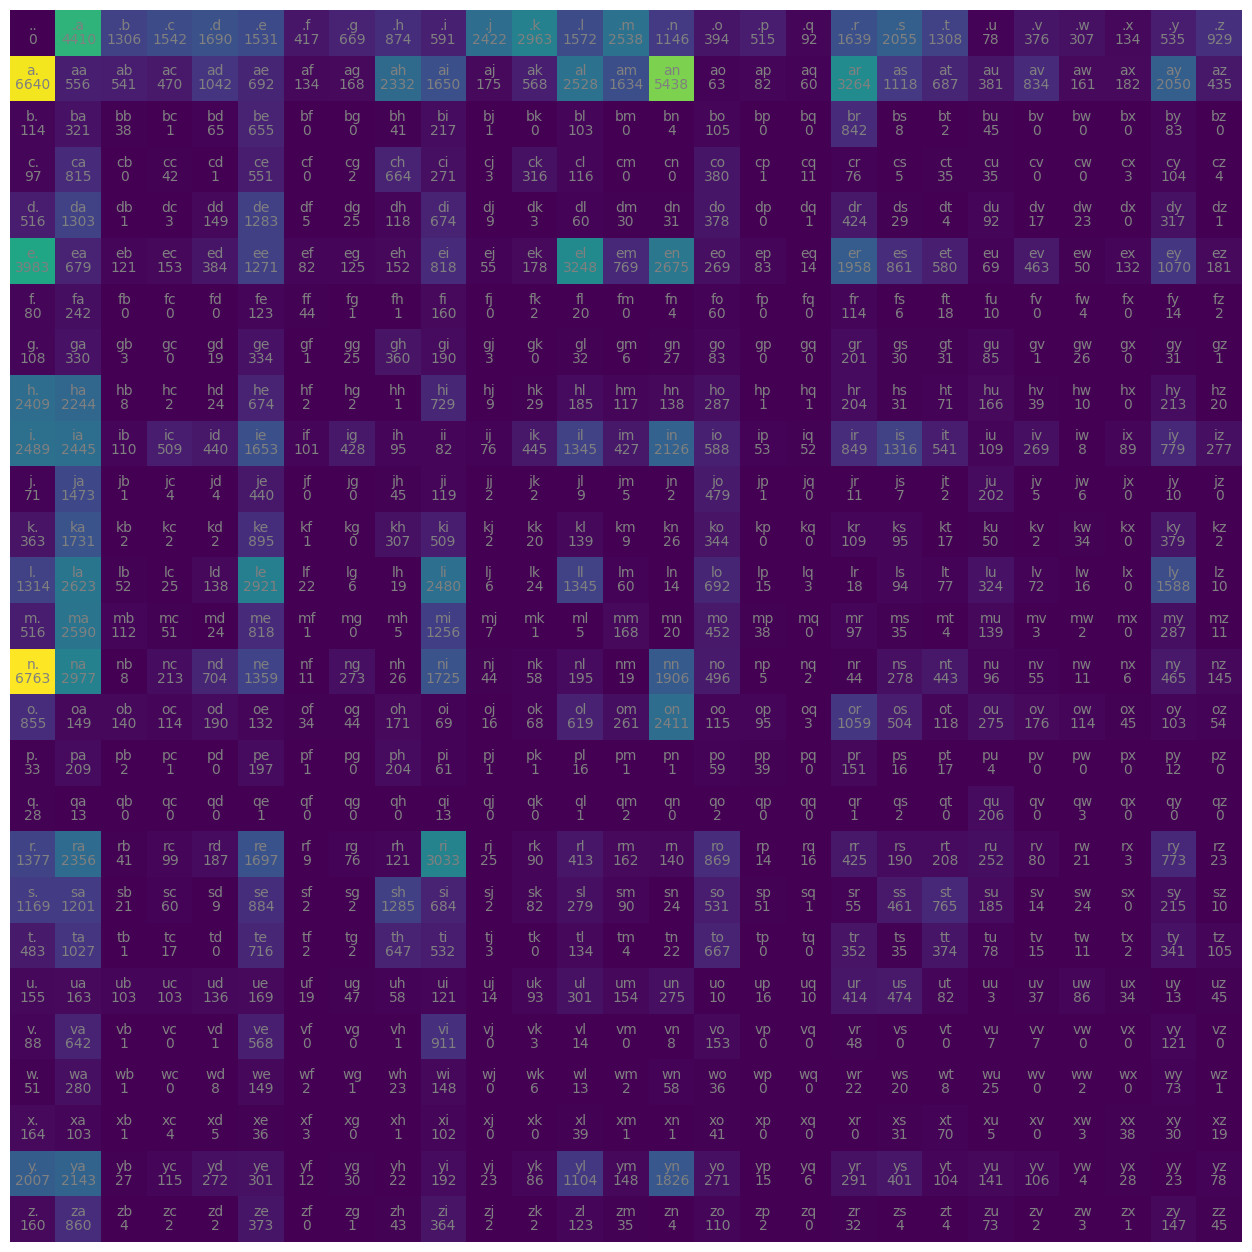

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(N)
for i in range(len(stoi)):
    for j in range(len(stoi)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
plt.axis('off')

In [112]:
p = N[0].float()
p /= p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [114]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

In [87]:
seed = 2147483647
g = torch.Generator().manual_seed(seed)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [89]:
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [171]:
# Build probability distribution matrix from counts
P = N.float()
P /= P.sum(1, keepdim=True)

In [152]:
# Broadcasting note: Why is the keepdim above necessary?

A = torch.tensor([[ 1, 2],
                  [ 4, 3]])
print(A.sum(1)) # [2]
# 2, 2
#    2
print(A / A.sum(1))

print(A.sum(1, keepdim=True))  # [2, 1]
# 2, 2
# 2, 1
print(A / A.sum(1, keepdim=True))


tensor([3, 7])
tensor([[0.3333, 0.2857],
        [1.3333, 0.4286]])
tensor([[3],
        [7]])
tensor([[0.3333, 0.6667],
        [0.5714, 0.4286]])


In [173]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))


cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


# Quality Evaluation

In [185]:
BASE = 1 / len(stoi)

log_likelihood = 0
n = 0
for w in words:
    chs = ['.']  + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        log_likelihood += torch.log(prob)
        n += 1
print(f"{log_likelihood:0.4f}")
nll = - log_likelihood
print(f"{nll:0.4f}")
# Goal is to maximize likelihood of the data w.r.t. model parameters (statistical modeling).
# Equivalent to maximizing log likelihood because log is monotonic
# Equivalent to minimizing negative log likelihood 
# Equivalent to minimizing the average negative log likelihood
# These are all equivalent optimization problems.
loss = nll/n
print(f"{loss:0.4f}")


.e 0.0478 -77.7680
em 0.0377 -77.7680
mm 0.0253 -77.7680
ma 0.3899 -77.7680
a. 0.1960 -77.7680
.o 0.0123 -77.7680
ol 0.0780 -77.7680
li 0.1777 -77.7680
iv 0.0152 -77.7680
vi 0.3541 -77.7680
ia 0.1381 -77.7680
a. 0.1960 -77.7680
.a 0.1377 -77.7680
av 0.0246 -77.7680
va 0.2495 -77.7680
a. 0.1960 -77.7680
.i 0.0184 -77.7680
is 0.0743 -77.7680
sa 0.1482 -77.7680
ab 0.0160 -77.7680
be 0.2476 -77.7680
el 0.1590 -77.7680
ll 0.0964 -77.7680
la 0.1879 -77.7680
a. 0.1960 -77.7680
.s 0.0642 -77.7680
so 0.0655 -77.7680
op 0.0120 -77.7680
ph 0.1988 -77.7680
hi 0.0957 -77.7680
ia 0.1381 -77.7680
a. 0.1960 -77.7680
.c 0.0481 -77.7680
ch 0.1880 -77.7680
ha 0.2946 -77.7680
ar 0.0963 -77.7680
rl 0.0325 -77.7680
lo 0.0496 -77.7680
ot 0.0149 -77.7680
tt 0.0671 -77.7680
te 0.1285 -77.7680
e. 0.1950 -77.7680
.m 0.0792 -77.7680
mi 0.1891 -77.7680
ia 0.1381 -77.7680
a. 0.1960 -77.7680
.a 0.1377 -77.7680
am 0.0482 -77.7680
me 0.1232 -77.7680
el 0.1590 -77.7680
li 0.1777 -77.7680
ia 0.1381 -77.7680
a. 0.1960 -7